1. Write a query to find the average salary both yearly (salary_year_avg) and hourly (salary_hour_avg) for job postings that were posted after June 1, 2023. Group the results by job schedule type.

In [ ]:
SELECT
    AVG(salary_year_avg) AS salary_year_avg,
    AVG(salary_hour_avg) AS salary_hour_avg,
    job_schedule_type
FROM job_postings_fact
WHERE job_posted_date > '2023-06-01'
    AND (salary_year_avg IS NOT NULL
    OR salary_hour_avg IS NOT NULL)
GROUP BY job_schedule_type
;

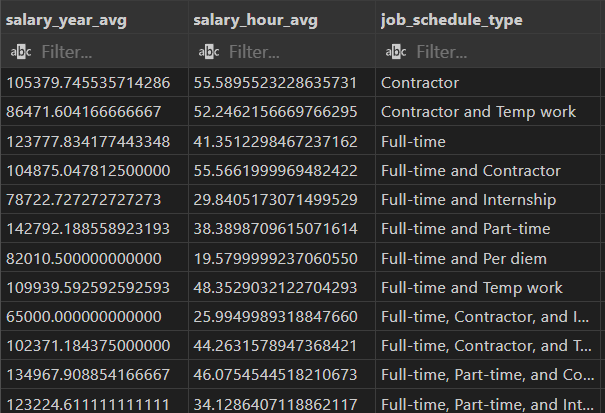